# Arbitrary Style Transfer in Real-time with Adaptive Instance Normalization

-  Based on the article of X. Huang & S. Belongie (2017)
-  Code based on the following Github using Python :  https://github.com/naoto0804/pytorch-AdaIN

### Project INSA HDDL 
### Minh Hai Nguyen, Cam Thanh Ha Le, Julie Tryoen, Flavie Kolb 


The neural algorithm presented in this paper is related to style transfer, which consists in render a content image in the style of another image. 
It relies on a style transfer network which takes a content image $c$ and a style image $s$ as inputs, and synthesizes an output image that recombines the content of the image $c$ with the style of the image $s$.

Previous work had already been proposed to achieve this task. Gatys & al. (2016) were the precursors in this domain. They showed that deep neural networks (DNNs) encode not only the content but also the style information of an image. Moreover, the image style and content are somewhat separable : it is possible to change the style of an image while preserving its content. They proposed the first style transfer method which demonstrates real good results by matching feature statistics in convulational layers of a DNN.

Their framework allows to deal with arbitrary style image, however it requires a slow optimization process that iteratively updates the image to minimize a content loss and a style loss computed by a loss network. Therefore, its practical application is limited. To speed up neural style transfer, some people proposed feed-forward neural networks that perform stylization with a single forward pass. But those methods are very limited, as each network is restricted to a fixed set of styles.

Huang and Belongie proposed in this paper the first effective approach that transfers arbitrary new-styles in real-time, therefore combining the flexibility of the optimization-based framework of Gatys & al. with a speed similar to the fastest feed-forward approaches.

Their architecture network is an encoder-decoder with an Adaptive Instance Normalization layer in between, inspired by the Instance Normalization layer already existing in feed-forward style transfer.

## Libraries importation

In [ ]:
from pathlib import Path
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data

import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms
from torchvision.utils import save_image
from PIL import Image 
Image.MAX_IMAGE_PIXELS = 10000000000 
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

from tqdm import tqdm

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Style transfer architecture

First, we take a look at our general architecture of style transfer model.

Our style transfer network $T$ takes a content image $c$ and a style image $s$ as inputs, and return an output image which combines the content of $c$ and the style of $s$.

We adopt a simple encoder-decoder architecture, where the encoder f is fixed to the first few layers (up to relu4 1) of a pre-trained VGG-19. After encoding the content and style images in feature space, we pass through an AdaIN:
$$ t = AdaIn(f(c),f(s))$$

The decoder $g$ is trained to map $t$ back to the image space, generating the stylized image $T(c, s)$ as output:
$$ T(c,s) = g(t)$$

**Architecture:** A drawing of the Style Transfer Model is given below. 

![Link](architecture.jpg)

## VGG-19 as the Encoder

A pretrained VGG-19, denoted by $f$, is first used as an encoder to extract the features of the content image $c$ and the style image $s$, namely $f(c)$ and $f(s)$. Below is the updated version of VGG19 provided by Pytorch. In fact, only the first layers up to relu4_1 will be used.

In [ ]:
# The encoder available at https://github.com/naoto0804/pytorch-AdaIN
encoder = nn.Sequential(
    nn.Conv2d(3, 3, (1, 1)),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(3, 64, (3, 3)),
    nn.ReLU(),  # relu1-1
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64, 64, (3, 3)),
    nn.ReLU(),  # relu1-2
    nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64, 128, (3, 3)),
    nn.ReLU(),  # relu2-1
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128, 128, (3, 3)),
    nn.ReLU(),  # relu2-2
    nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128, 256, (3, 3)),
    nn.ReLU(),  # relu3-1
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),  # relu3-2
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),  # relu3-3
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),  # relu3-4
    nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 512, (3, 3)),
    nn.ReLU(),  # relu4-1, this is the last layer used for the style loss and for 
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(),  # relu4-2
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(),  # relu4-3
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(),  # relu4-4
    nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(),  # relu5-1
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(),  # relu5-2
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(),  # relu5-3
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU()  # relu5-4
)

## Adaptive Instance Normalization Layer

In [ ]:
class AdaptiveIN(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, content_feat, style_feat):
        return adaptive_instance_normalization(content_feat, style_feat)

def adaptive_instance_normalization(content_feat, style_feat):
    assert (content_feat.size()[:2] == style_feat.size()[:2])
    size = content_feat.size()
    style_mean, style_std = calc_mean_std(style_feat)
    content_mean, content_std = calc_mean_std(content_feat)

    normalized_feat = (content_feat - content_mean.expand(
        size)) / content_std.expand(size)
    return normalized_feat * style_std.expand(size) + style_mean.expand(size)

def calc_mean_std(feat, eps=1e-5):
    # eps is a small value added to the variance to avoid divide-by-zero.
    size = feat.size()
    assert (len(size) == 4)
    N, C = size[:2]
    feat_var = feat.view(N, C, -1).var(dim=2) + eps
    feat_std = feat_var.sqrt().view(N, C, 1, 1)
    feat_mean = feat.view(N, C, -1).mean(dim=2).view(N, C, 1, 1)
    return feat_mean, feat_std
    

An Adaptive Instance Normalization (AdaIN) is then achieved to align the mean and variance of the content feature maps to those of the style features maps, producing the target feature maps 
$$t = \text{AdaIN}(f(c),f(s))=\sigma(f(s)) \left( \frac{f(c)-\mu(f(c))}{\sigma(f(c))} \right) + \mu(f(c)).$$

Unlike the other normalization methods (BN, IN or CIN), AdaIN has no learnable affine parameters and is in fact an extension to IN. As IN, the mean and standard deviation are computed across spacial dimensions independently for each channel and each sample.

More precilely, given two inputs of the dimension $x, y \in \mathbb R^{N \times C \times H \times W }$, where as usual (in pytorch), $N, C, H, W$ denoted the `batch_size`, `number of channel`, `height` and `width` respectively, the output of the AdaIN Layer is also in  $\mathbb R^{N \times C \times H \times W }$ and calculated as
$$\text{AdaIN}(x, y)_{n,c} = \sigma(y_{n,c}) \left( \frac{x_{n,c} - \mu(x_{n,c})}{\sigma(x_{n,c})} \right) + \mu(y_{n,c}) \text{ for } n = 0,1,...,N-1 \text{ and } c = 0,1, ..., C-1$$
where

$$\mu_(x_{n,c}) = \frac {1}{H W} \sum_{h=1}^H \sum_{w=1}^W x_{n, c, h, w},$$
$$\sigma_{n,c} = \sqrt{\frac {1}{H W} \sum_{h=1}^H \sum_{w=1}^W ( x_{n, c, h, w} - \mu(x_{n,c}))^2 + \epsilon }.$$
and $\epsilon$ is a small positive constant (for example $1e-5$) for numerical stability (avoid divided by zero)

## The Decoder

A Decoder $g$, which mostly mirrors the encoder, is finally used to map the target feature map $t$ back to the image space, generating the stylized image $T(c,s) = g(t)$.

In [ ]:
decoder = nn.Sequential(
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 256, (3, 3)),
    nn.ReLU(),
    nn.Upsample(scale_factor=2, mode='nearest'),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 128, (3, 3)),
    nn.ReLU(),
    nn.Upsample(scale_factor=2, mode='nearest'),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128, 128, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128, 64, (3, 3)),
    nn.ReLU(),
    nn.Upsample(scale_factor=2, mode='nearest'),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64, 64, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64, 3, (3, 3)),
)

## Style Transfer Model and loss function

The part of the model which will be trained is the decoder $g$. The training is performed with a loss function using not only $g$ but also the pre-trained VGG encoder $f$. The loss function $\mathcal L$ is a weighted combination of the content loss $\mathcal L_c$ and the style loss $\mathcal L_s$ with the style loss weight $\lambda$, allowing to adjust the compromise between content and style :

$$\mathcal L = \mathcal L_c + \lambda \mathcal L_s.$$

The content loss corresponds to the mean-squared error between the target features $t$ and the features of the output image $f(g(t))$ :

$$\mathcal L_c = \lVert f(g(t)) - t \rVert_2.$$

The style loss corresponds to the sum of the mean-squared errors between the mean and standard deviation of the the style image $s$ and the stylized image $g(t)$, computed for each layer $\phi_i$ (L is the total number of layers) in the encoder $f$ :

$$\mathcal L_s = \sum_{i=1}^L \lVert \mu(\phi_i(g(t))) - \mu(\phi_i(s))\rVert_2 + \sum_{i=1}^L \lVert \sigma(\phi_i(g(t))) - \sigma(\phi_i(s)) \rVert_2.$$

In [ ]:
class StyleTransferNet(nn.Module):
    def __init__(self, encoder, decoder, style_loss_index = [4, 9, 16, 23, 32, 37]):
        super(StyleTransferNet, self).__init__()
        # Want to fix the encoder, disable require grad
        for _, param in encoder.named_parameters():
            param.requires_grad = False

        encoder_layers = list(encoder.children())
        self.n_style_checkpoints = len(style_loss_index)
        style_loss_index.insert(0, 0)

        self.style_loss_checkpoints = [
            nn.Sequential(*encoder_layers[style_loss_index[i]:style_loss_index[i+1]])
            for i in range(len(style_loss_index) - 1)
        ]

        self.encoder = encoder
        self.decoder = decoder
        self.mse_loss = nn.MSELoss()        

    # Encode the style image and store the intermediate values for 
    # calculating style loss 
    def encode_with_intermediate(self, input):
        # encode the input image and store the intermediate value for 
        # calculating the final style loss
        results = [input]
        for i in range(self.n_style_checkpoints):
            func = self.style_loss_checkpoints[i]
            results.append(func(results[-1]))
        return results[1:]

    # Encode the input image to get the features
    def encode(self, input):
        for i in range(self.n_style_checkpoints):
            input = self.style_loss_checkpoints[i](input)
        return input

    # Content loss: (encoder(decoder(input)) - input)).norm()
    def calc_content_loss(self, input, target):
        assert (input.size() == target.size())
        assert (target.requires_grad is False)
        return self.mse_loss(input, target)

    # Style loss 
    def calc_style_loss(self, input, target):
        """
        Style loss for a single couple of (input, target) images
        """
        assert (input.size() == target.size())
        assert (target.requires_grad is False)
        input_mean, input_std = calc_mean_std(input)
        target_mean, target_std = calc_mean_std(target)
        return self.mse_loss(input_mean, target_mean) + \
               self.mse_loss(input_std, target_std)

    def forward(self, content, style, alpha=1.0):
        assert 0 <= alpha <= 1    # constant to adjust the compromise between content and style
        style_feats = self.encode_with_intermediate(style)   # intermediate values during encoding 
        content_feat = self.encode(content)   # f(c)
        t = adaptive_instance_normalization(content_feat, style_feats[-1])     # t = AdapIN(f(c))
        t = alpha * t + (1 - alpha) * content_feat

        # g(t) - the generated image by the decoder
        g_t = self.decoder(t)     
        # Re-passing the generated image to the encoder for calculating losses  
        g_t_feats = self.encode_with_intermediate(g_t)     

        # Content loss between t = f(c) and f(g(t))
        loss_c = self.calc_content_loss(g_t_feats[-1], t)
        # Style loss during encoding-phase between s and f(g(t))
        # it's the sum over pre-selected layers of encoder
        loss_s = torch.sum(torch.stack([
            self.calc_style_loss(g_t_feats[i], style_feats[i]) for i in range(self.n_style_checkpoints) 
        ]))
        
        return loss_c, loss_s

### Load weights from pre-trained models

For inference purpose, we will use the pre-trained models that are available at 

In [ ]:
import gdown 
import os 

if not os.path.exists("./models/"):
    os.makedirs("./models/")

vgg_url = "https://drive.google.com/u/0/uc?id=1EpkBA2K2eYILDSyPTt0fztz59UjAIpZU&export=download"
decoder_url = "https://drive.google.com/u/0/uc?id=1YIBRdgGBoVllLhmz_N7PwfeP5V9Vz2Nr&export=download"

gdown.download(vgg_url, "./models/vgg19.pth", quiet=False)
gdown.download(decoder_url, "./models/decoder.pth", quiet=False)


Downloading...
From: https://drive.google.com/u/0/uc?id=1EpkBA2K2eYILDSyPTt0fztz59UjAIpZU&export=download
To: /content/models/vgg19.pth
100%|██████████| 80.1M/80.1M [00:01<00:00, 46.4MB/s]
Downloading...
From: https://drive.google.com/u/0/uc?id=1YIBRdgGBoVllLhmz_N7PwfeP5V9Vz2Nr&export=download
To: /content/models/decoder.pth
100%|██████████| 14.0M/14.0M [00:00<00:00, 44.0MB/s]


'./models/decoder.pth'

In [ ]:
# Load encoder and decoder
encoder.load_state_dict(torch.load("./models/vgg19.pth"))
decoder.load_state_dict(torch.load("./models/decoder.pth"))



<All keys matched successfully>


## Inference - Test with images

The function below allows to take an input image of 

In [ ]:
def test_transform(size, crop):
    """
    Transform an input images to by resizing and cropping.
    Args: size (int) - desired size
          crop (boolean) - crop or not
    """
    transform_list = []
    if size != 0:
        transform_list.append(transforms.Resize(size))
    if crop:
        transform_list.append(transforms.CenterCrop(size))
    transform_list.append(transforms.ToTensor())
    transform = transforms.Compose(transform_list)
    return transform


def style_transfer(vgg, decoder, content, style, alpha=1.0,
                   interpolation_weights=None):
    """
    Function to transfer the style between content image and style image
    Args: vgg - the encoder model 
          decoder - the decoder model
          content - input content image
          style - input style image
          alpha - constant to calibrate the style-content compromise
    """

    assert (0.0 <= alpha <= 1.0)
    content_f = vgg(content)
    style_f = vgg(style)
    if interpolation_weights:
        _, C, H, W = content_f.size()
        feat = torch.FloatTensor(1, C, H, W).zero_().to(device)
        base_feat = adaptive_instance_normalization(content_f, style_f)
        for i, w in enumerate(interpolation_weights):
            feat = feat + w * base_feat[i:i + 1]
        content_f = content_f[0:1]
    else:
        feat = adaptive_instance_normalization(content_f, style_f)
    feat = feat * alpha + content_f * (1 - alpha)
    return decoder(feat)

In [ ]:
def calc_mean_std(feat, eps=1e-5):
    # eps is a small value added to the variance to avoid divide-by-zero.
    size = feat.size()
    assert (len(size) == 4)
    N, C = size[:2]
    feat_var = feat.view(N, C, -1).var(dim=2) + eps
    feat_std = feat_var.sqrt().view(N, C, 1, 1)
    feat_mean = feat.view(N, C, -1).mean(dim=2).view(N, C, 1, 1)
    return feat_mean, feat_std


def adaptive_instance_normalization(content_feat, style_feat):
    assert (content_feat.size()[:2] == style_feat.size()[:2])
    size = content_feat.size()
    style_mean, style_std = calc_mean_std(style_feat)
    content_mean, content_std = calc_mean_std(content_feat)

    normalized_feat = (content_feat - content_mean.expand(
        size)) / content_std.expand(size)
    return normalized_feat * style_std.expand(size) + style_mean.expand(size)


def _calc_feat_flatten_mean_std(feat):
    # takes 3D feat (C, H, W), return mean and std of array within channels
    assert (feat.size()[0] == 3)
    assert (isinstance(feat, torch.FloatTensor))
    feat_flatten = feat.view(3, -1)
    mean = feat_flatten.mean(dim=-1, keepdim=True)
    std = feat_flatten.std(dim=-1, keepdim=True)
    return feat_flatten, mean, std


def _mat_sqrt(x):
    U, D, V = torch.svd(x)
    return torch.mm(torch.mm(U, D.pow(0.5).diag()), V.t())


def coral(source, target):
    # assume both source and target are 3D array (C, H, W)
    # Note: flatten -> f

    source_f, source_f_mean, source_f_std = _calc_feat_flatten_mean_std(source)
    source_f_norm = (source_f - source_f_mean.expand_as(
        source_f)) / source_f_std.expand_as(source_f)
    source_f_cov_eye = \
        torch.mm(source_f_norm, source_f_norm.t()) + torch.eye(3)

    target_f, target_f_mean, target_f_std = _calc_feat_flatten_mean_std(target)
    target_f_norm = (target_f - target_f_mean.expand_as(
        target_f)) / target_f_std.expand_as(target_f)
    target_f_cov_eye = \
        torch.mm(target_f_norm, target_f_norm.t()) + torch.eye(3)

    source_f_norm_transfer = torch.mm(
        _mat_sqrt(target_f_cov_eye),
        torch.mm(torch.inverse(_mat_sqrt(source_f_cov_eye)),
                 source_f_norm)
    )

    source_f_transfer = source_f_norm_transfer * \
                        target_f_std.expand_as(source_f_norm) + \
                        target_f_mean.expand_as(source_f_norm)

    return source_f_transfer.view(source.size())

In [ ]:
#Parameters
import os
content_names = ["content2.jpg"]
content_paths = [os.path.join("input/content/", content_name) for content_name in content_names]
style_names = ["style1.jpg"]
style_paths = [os.path.join("input/style/", style_name) for style_name in style_names]
output_dir = "output/"

content_size = 512
style_size = 512
crop = False
preserve_color = False
alpha = 1
save_ext = ".png"

interpolation_weights = None
do_interpolation = False


output/stylized_content2.png


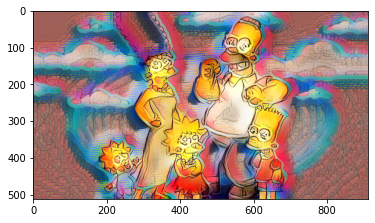

In [ ]:
decoder.eval()
encoder.eval()

# encoder = nn.Sequential(*list(encoder.children())[:31])

encoder.to(device)
decoder.to(device)

content_tf = test_transform(content_size, crop)
style_tf = test_transform(style_size, crop)


for content_path in content_paths:
    if do_interpolation:  # one content image, N style image
        style = torch.stack([style_tf(Image.open(p)) for p in style_paths])
        content = content_tf(Image.open(content_path)).unsqueeze(0).expand_as(style)
        style = style.to(device)
        content = content.to(device)
        with torch.no_grad():
            output = style_transfer(encoder, decoder, content, style,
                                    alpha, interpolation_weights)
        output = output.cpu()

        output_name = content_path.split("/")[-1][:-4]
        output_path = os.path.join(output_dir, f"interpolation{output_name}" + save_ext)
        print(output_path)
        save_image(output, output_path)

    else:  # process one content and one style
        for style_path in style_paths:
            content = content_tf(Image.open(content_path))
            style = style_tf(Image.open(style_path))
            if preserve_color:
                style = coral(style, content)
            style = style.to(device).unsqueeze(0)
            content = content.to(device).unsqueeze(0)
            with torch.no_grad():
                output = style_transfer(encoder, decoder, content, style,
                                        alpha)
            output = output.cpu()

            output_name = content_path.split("/")[-1][:-4]
            output_path = os.path.join(output_dir, f"stylized_{output_name}" + save_ext)
            print(output_path)
            save_image(output, output_path)

plt.imshow(output.squeeze().permute(1,2,0))

In [ ]:
content_path.split("/")[-1][:-4]

'content1'

## Training the Color Transfer Model

### Download training data


Below is a script for downloading the training dataset. 

The content images are taken from the [COCO Dataset](https://cocodataset.org/#home) and the style images are taken from [Wikiart Dataset](https://www.kaggle.com/competitions/painter-by-numbers/) 

In [ ]:
# Full 2017 train images from COCO
# !wget http://images.cocodataset.org/zips/train2017.zip
# 2017 Validation set (~5k images, 1GB)
# !wget http://images.cocodataset.org/zips/val2017.zip
# Full wikiart dataset from kaggle
# !wget https://storage.googleapis.com/kagglesdsdata/competitions/5127/868727/train.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1669156192&Signature=N1x%2BVHnHmgIMVB8goyd8s%2F7vdht0gttXBnA%2FJ4RfBebx67cR8lt0ghsRV7KK%2B2S5%2BEdiR7oMf%2BzBrHi7bT4Yw4rdXvBi9PKPAgKcWRQMoKUvidMQt05LY4imjpIzg3WuQRz04MKy4NV%2Fc9Hhd83s9b%2Bgx%2FzKTApxnELUsHpdS61WEvBThH8NtdZOU6X0%2BgnOLcrseMGqE%2BKRiSLjKzF3yZ4%2FRYAtrlpbe%2Fhdz6nj9FSWBOfws6Yvynr3TqhB%2FLAzOYV%2BY8N3%2By7G53PjRPsN5jFR%2FeA81EWy0a8lhejbaiuHsd4IcbIL1ExWE1oIK4xDuKdb2nEDy2pGk%2FKY%2BdeRSA%3D%3D&response-content-disposition=attachment%3B+filename%3Dtrain.zip
# A small subset 
# !wget https://storage.googleapis.com/kagglesdsdata/competitions/5127/868727/train_1.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1669156268&Signature=XieI3fwZReUSBmiXZ2ov25fQAoxpqIiOgITk%2BFZ2cFnEthTrcHpSd2tk%2BrkY3%2FcfRxWgZ%2BoSdQR4BMJYfLo9rCCOD4Hg75SL5AhTZKdEGTkzOeKfR7LJkveSGCVH8euqQNFaE3x%2FaSbyNYk%2BuqBi%2BXIRxlIXeOghmnXPDEe4Gp1QbQk1M83YWl0YAgqTqT77ZXGmOb89wP2sXtnWVmbjPnDBDLWj6vI76FoK7fZgrqJJD4jFPCXnVKWDdK%2FRgho45Q%2Fr8zQRSBDGahwd5dOFydSwXdtPSOS4s4%2BsWsmfxYpzsvlPFidJLSXK%2Fle7kFYcNSn%2FKda7n65ISfJuJD1bjA%3D%3D&response-content-disposition=attachment%3B+filename%3Dtrain_1.zip



### Dataset and Dataloader

In [ ]:
class FlatFolderDataset(data.Dataset):
    def __init__(self, root, transform):
        super(FlatFolderDataset, self).__init__()
        self.root = root
        self.paths = list(Path(self.root).glob('*'))
        self.transform = transform

    def __getitem__(self, index):
        path = self.paths[index]
        img = Image.open(str(path)).convert('RGB')
        img = self.transform(img)
        return img

    def __len__(self):
        return len(self.paths)

    def name(self):
        return 'FlatFolderDataset'

def train_transform(size = (256,256)):
    transform_list = [
        transforms.Resize(size=(512, 512)),
        transforms.RandomCrop(size=size),
        transforms.ToTensor()
    ]
    return transforms.Compose(transform_list)

def reset_lr(optimizer, new_lr):
    for param_group in optimizer.param_groups:
        param_group['lr'] = new_lr

Define Dataset

In [ ]:
content_path = "./data/train2014/"
style_path = "./data/test/"
train_tf = train_transform(size = (256,256))
content_dataset = FlatFolderDataset(content_path, train_tf)
style_dataset = FlatFolderDataset(style_path, train_tf)

Training parameters

In [ ]:
def InfiniteSampler(n):
    # i = 0
    i = n - 1
    order = np.random.permutation(n)
    while True:
        yield order[i]
        i += 1
        if i >= n:
            np.random.seed()
            order = np.random.permutation(n)
            i = 0


class InfiniteSamplerWrapper(data.sampler.Sampler):
    def __init__(self, data_source):
        self.num_samples = len(data_source)

    def __iter__(self):
        return iter(InfiniteSampler(self.num_samples))

    def __len__(self):
        return 2 ** 31

In [ ]:
save_dir = "./experiments"
lr = 1e-4
scheduler = {"reset_every": 10000, "scale": 0.9}
max_iter = 160000
batch_size = 8
style_weight = 10
content_weight = 1
n_threads = 16
save_model_interval = 10000

### Training loop 

In [ ]:
# The updated version of VGG19 provided by PyTorch
encoder = torchvision.models.vgg19(weights = "VGG19_Weights.DEFAULT", progress = True).features

decoder = nn.Sequential(
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 256, (3, 3)),
    nn.ReLU(),
    nn.Upsample(scale_factor=2, mode='nearest'), #increase the spatial resolution of the feature maps
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 128, (3, 3)),
    nn.ReLU(),
    nn.Upsample(scale_factor=2, mode='nearest'), #increase the spatial resolution of the feature maps
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128, 128, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128, 64, (3, 3)),
    nn.ReLU(),
    nn.Upsample(scale_factor=2, mode='nearest'),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64, 32, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(32, 32, (3, 3)),

    # new
    nn.Upsample(scale_factor=2, mode='nearest'),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(32, 16, (3, 3)),

    nn.Upsample(scale_factor=2, mode='nearest'),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(16, 3, (3, 3)),

)

In [ ]:
trained_state_dict = torch.load("./models/decoder.pth")
# 1. filter out unnecessary keys
trained_state_dict = {k: v for k, v in trained_state_dict.items() if k in decoder.state_dict()}
# 2. overwrite entries in the existing state dict
decoder.state_dict().update(trained_state_dict) 

net = StyleTransferNet(encoder, decoder)

In [ ]:
net.train()
net.to(device)

content_iter = iter(data.DataLoader(content_dataset, batch_size, shuffle=True))
style_iter = iter(data.DataLoader(style_dataset, batch_size, shuffle=True))

optimizer = torch.optim.Adam(net.decoder.parameters(), lr=lr)

loss_content = []
loss_style = []

for i in range(max_iter):
    if i % scheduler["reset_every"] == 0:
        lr = lr * scheduler["scale"]
        reset_lr(optimizer, lr)


    content_images = next(content_iter).to(device)
    style_images = next(style_iter).to(device)
    loss_c, loss_s = net(content_images, style_images)
    loss_c = content_weight * loss_c
    loss_s = style_weight * loss_s
    loss = loss_c + loss_s

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loss_content.append(loss_c.item())
    loss_style.append(loss_s.item())

    if (i + 1 ) % 500 == 0 or i == 0:
        print(f"Iteration {i}, content loss {loss_c.item():.2f}, style loss {loss_s.item():.2f}")


    if (i + 1) % save_model_interval == 0 or (i + 1) == max_iter:
        state_dict = net.decoder.state_dict()
        for key in state_dict.keys():
            state_dict[key] = state_dict[key].to(torch.device('cpu'))
        
        torch.save(state_dict, save_dir /
                'decoder_iter_{:d}.pth.tar'.format(i + 1))


Iteration 0, content loss 0.27, style loss 40.71
Iteration 499, content loss 0.31, style loss 12.45


OSError: image file is truncated (79 bytes not processed)

## Gradio Application

In [ ]:
import gradio as gr

In [ ]:
content = np.array(Image.open("input/content/content1.jpg"))
style = np.array(Image.open("input/style/style1.jpg"))


In [ ]:
def application(content, style, alpha=1, crop=False, preserve_color=False, content_size=256, style_size=256):
    content_tf = test_transform(content_size, crop)
    style_tf = test_transform(style_size, crop)
    style = style_tf(style)
    content = content_tf(content)
    # process one content and one style
    if preserve_color:
        style = coral(style, content)

    style = style.to(device).unsqueeze(0)
    content = content.to(device).unsqueeze(0)
    with torch.no_grad():
        output = style_transfer(encoder, decoder, content, style,
                                alpha)
    output = output.cpu()
    return output.squeeze().permute(1, 2, 0).numpy().clip(-1,1)



demo = gr.Interface(fn = application, 
    inputs = [gr.Image(type="pil"),gr.Image(type="pil"), gr.Slider(0,1), "checkbox", "checkbox"],
    outputs = gr.Image())
demo.launch(share=True)


Running on local URL:  http://127.0.0.1:7879
Running on public URL: https://5ad5a3972691b552.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces: https://www.huggingface.co/spaces


(<gradio.routes.App at 0x7fcd60086b20>,
 'http://127.0.0.1:7879/',
 'https://5ad5a3972691b552.gradio.app')